In [51]:
#import library
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time

In [52]:
# IMAGES PATH
dataset_path = '../data/ENZ_crop/'
# CSV PATH
df = pd.read_csv('../data/data_618_final.csv')

# CHANGE COLUMN NAME
df['Depth(km)'] = df['Depth']
df.drop('Depth',axis=1,inplace=True)
df['foldername'] = df['filename'].apply(lambda x: x+'crop')

df

,Unnamed: 0,No,filename,Date,Hr,Min,Sec,Lat,Long,Mag,...,seconds,time,foldername,PA,cluster_class,norm_lat,norm_long,norm_magnitude,norm_depth,Depth(km)
0,636,670,20170428_014929,28/04/2017,1,49,29,-8.08697,111.716,3.4,...,16.024,16.024,20170428_014929crop,200,1,-8.08697,111.716,3.4,126.932,126.932


In [53]:
## SELECT PA VALUES
df['PA'] = df.apply(lambda x: x['flag_start']-75 if x['Unpick']!=0 else x['PA_start']-75,axis=1)
df = df[df.PA>=0]
df['PA'] = df.PA.apply(lambda x: int(x))

## CREATE PA DICTIONARIES
PA = {}
for i in range(df.shape[0]):
    PA[df.filename.values[i]+"crop"] = df.PA.values[i]

df

,Unnamed: 0,No,filename,Date,Hr,Min,Sec,Lat,Long,Mag,...,seconds,time,foldername,PA,cluster_class,norm_lat,norm_long,norm_magnitude,norm_depth,Depth(km)
0,636,670,20170428_014929,28/04/2017,1,49,29,-8.08697,111.716,3.4,...,16.024,16.024,20170428_014929crop,200,1,-8.08697,111.716,3.4,126.932,126.932


In [54]:
print('Max Lat:',df['Lat'].max(),'\t\tMin Lat:',df['Lat'].min())
print('Max Long:',df['Long'].max(),'\tMin Long:',df['Long'].min())
print('Max Depth(km):',df['Depth(km)'].max(),'\tMin Depth(km):',df['Depth(km)'].min())
print('Max Mag:',df['Mag'].max(),'\t\tMin Mag:',df['Mag'].min())
print('Max Time:',df['time'].max(),'\t\tMin Time:',df['time'].min())

Max Lat: -8.086969999999999 		Min Lat: -8.086969999999999
Max Long: 111.716 	Min Long: 111.716
Max Depth(km): 126.932 	Min Depth(km): 126.932
Max Mag: 3.4 		Min Mag: 3.4
Max Time: 16.024 		Min Time: 16.024


In [55]:
### NORMALIZATION
#coef_norm_lat = 3 
coef_norm_lat = df['Lat'].max() - df['Lat'].min() # min-max-normalization 0-1 

#coef_norm_long = 3
coef_norm_long = df['Long'].max() - df['Long'].min() # min-max-normalization 0-1

#coef_norm_mag = 6
coef_norm_magnitude = df['Mag'].max() - df['Mag'].min() # min-max-normalization 0-1

#coef_norm_mag = 6
coef_norm_depth = df['Depth(km)'].max() - df['Depth(km)'].min() # min-max-normalization 0-1

#coef_norm_time = 6
coef_norm_time = df['time'].max() - df['time'].min() # min-max-normalization 0-1

df['norm_lat'] = df['Lat'].apply(lambda x: (x - df['Lat'].min()) / coef_norm_lat)
df['norm_long'] = df['Long'].apply(lambda x: (x - df['Long'].min()) / coef_norm_long)
df['norm_magnitude'] = df['Mag'].apply(lambda x: (x - df['Mag'].min()) / coef_norm_magnitude)
df['norm_depth'] = df['Depth(km)'].apply(lambda x: (x - df['Depth(km)'].min()) / coef_norm_depth)
df['norm_time'] = df['time'].apply(lambda x: (x - df['time'].min()) / coef_norm_time)

(616, 423, 3)
(256, 192, 3)


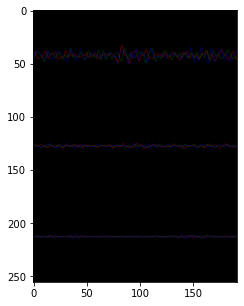

In [56]:
import cv2
import matplotlib.pyplot as plt

#get image size from dataset
img = load_img(dataset_path+'20170428_014929crop/'+'000000_20170428_014929_crop.png')  # this is a PIL image
x = img_to_array(img)
print(x.shape)
plt.figure(figsize=(5,5))
x = cv2.resize(x, (192, 256))
# x = cv2.resize(x, (x.shape[1]//2,x.shape[0]//2))
print(x.shape)
plt.imshow(x/255)

In [57]:
test_df = pd.read_csv('../data/data_test_val_final2.csv')
test_df = df[df.foldername.isin(test_df.foldername.values)]  ## TESTSET is only 1 example data avaliable
train_df = df[~df.foldername.isin(test_df.foldername.values)] ## TRAINSET might 0 because the data is unsharable

list_folder_for_train = [__ for __ in train_df.foldername.values]
list_folder_for_validation = [__ for __ in test_df.foldername.values]
list_folder_for_test = list_folder_for_validation

print()
print('Pembagian Dataset:')
print('TRAIN:',len(list_folder_for_train))
print('VALIDATION:',len(list_folder_for_validation))
print('TEST:',len(list_folder_for_test))


Pembagian Dataset:
TRAIN: 0
VALIDATION: 1
TEST: 1


In [58]:
## Check redundant in train
for __ in list_folder_for_train:
    if __ in  list_folder_for_test+list_folder_for_validation:
        print(__)

In [59]:
#make folder test 
model_save_path = "./result_test/EXPERIMENT_001/"
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

## Prediction

In [60]:
folder_test_path = "./model_test/"
folder_model = os.listdir(folder_test_path)
model_path = {}
for folder_ in folder_model:
    try:
        model_path[folder_] = folder_test_path+folder_+"/"+os.listdir(folder_test_path+folder_)[0]
        print(folder_,":",model_path[folder_])
    except:
        pass

clustering : ./model_test/clustering/cluster32_model.sav
multi_lat_long_depth_magnitude_time : ./model_test/multi_lat_long_depth_magnitude_time/EFFICIENTNETB5_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_B_4_1x1024orto_paral512-256_best.h5
parrival : ./model_test/parrival/EFFICIENTNETB5_parival_5-6_ENZ_final_all_ep50_batch32_#1_best.h5


### Load model detection

In [61]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [62]:
from keras.models import *
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam

from keras.models import *
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam

def make_model_clf(custom_name_clf=""):
    m_ = None

    if custom_name_clf == "": raise "DEFINISI SALAH"
    
    base = custom_name_clf.split("_")[0]
    PA_start,PA_end = (pname for pname in custom_name_clf.split("_")[2].split("-"))
    


    if base.lower()=="cnn":
        ### FOR CNN MODELS ###

        base_model = Sequential()
        base_model.add(Conv2D(32, (3, 3), input_shape=(x.shape[0], x.shape[1], 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Conv2D(64, (3, 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Conv2D(128, (3, 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Conv2D(256, (3, 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Flatten()) 
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
        base_model.add(Dropout(0.5))
        base_model.add(Dense(64))
        base_model.add(Activation('relu'))
        m_ = base_model.output

        ### --------------- ###

    elif base.lower()=="mobilenetv3":
        ### FOR MOBILENETV3 ###

        import keras
        from keras.applications import keras_applications
        from keras_applications.mobilenet_v3 import MobileNetV3Large, MobileNetV3Small

        base_model = MobileNetV3Large(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet', backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils) #RGB 3, grayscale 1

        # RENAME LAYER TO SOLVE THE PROBLEM WHEN SAVING THE MODEL
        for i, layer in enumerate(base_model.layers[1:]):
            layer.name = 'layer_' + str(i) + '_' + layer.name

        m_ = base_model.output

        m_ = GlobalAveragePooling2D()(m_)
        m_ = Dense(1024,activation='relu')(m_) #we add dense layers so that the model can learn more complex functions and classify for better results.
        m_ = Dense(512,activation='relu')(m_) #dense layer 2
        m_ = Dense(256,activation='relu')(m_) #dense layer 3
        
        ### --------------- ###
    elif base.lower()[:-1]=="efficientnetb":
        ### FOR EFFICIENTNET ###

        from efficientnet.keras import EfficientNetB0,EfficientNetB1
        from efficientnet.keras import EfficientNetB2,EfficientNetB3
        from efficientnet.keras import EfficientNetB4,EfficientNetB5

        EFMODEL = {}
        EFMODEL['efficientnetb0'] = EfficientNetB0(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb1'] = EfficientNetB1(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb2'] = EfficientNetB2(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb3'] = EfficientNetB3(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb4'] = EfficientNetB4(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb5'] = EfficientNetB5(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1

        base_model = EFMODEL[base.lower()]
        # RENAME LAYER TO SOLVE THE PROBLEM WHEN SAVING THE MODEL
        for i, layer in enumerate(base_model.layers[1:]):
            layer.name = 'layer_' + str(i) + '_' + layer.name

        m_ = base_model.output

        m_ = GlobalAveragePooling2D()(m_)
        m_ = Dense(1024,activation='relu')(m_) #we add dense layers so that the model can learn more complex functions and classify for better results.
        m_ = Dense(512,activation='relu')(m_) #dense layer 2
        m_ = Dense(256,activation='relu')(m_) #dense layer 3
        
        ### --------------- ###
    else:
        print("Model Definition Error")
    
    outputs = Dense(1, activation = 'sigmoid')(m_) #final layer with sigmoid activation
        
    model = Model(inputs=base_model.input, outputs=outputs) 
    
    model.compile(optimizer=Adam(1e-4),
                  loss="binary_crossentropy",   
                  metrics=["accuracy",f1_m,precision_m, recall_m])
    
    model.name = custom_name_clf
    
    return model, PA_start, PA_end


In [63]:
model_clf, PA_start, PA_end = make_model_clf(model_path["parrival"].split('/')[-1])
mscore_clf = ["loss","accuracy","f1_m","precision_m", "recall_m"]
model_clf.load_weights(model_path["parrival"])

In [64]:
model_clf.name, PA_start, PA_end

('EFFICIENTNETB5_parival_5-6_ENZ_final_all_ep50_batch32_#1_best.h5', '5', '6')

### Load model prediction

*`WE SHOULD DEFINE EXACT SHARED-LAYER AND NON-SHARED-LAYER LIKE THE LOADED MODEL SOURCE! IF NOT, RESULT WILL BE DEGRADED`*

In [65]:
from keras.models import *
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam

loss_function = 'mae'

def make_model_reg(custom_name_reg=""):
    m_ = None
    outputs = {}
    
    if custom_name_reg == "": raise "DEFINISI SALAH"
    
    base = custom_name_reg.split("_")[0]
    output_names = [cname for cname in custom_name_reg.split("_") if cname in ['lat','long','depth','magnitude','time']]

    if base.lower()=="cnn":
        ### FOR CNN MODELS ###

        base_model = Sequential()
        base_model.add(Conv2D(32, (3, 3), input_shape=(x.shape[0], x.shape[1], 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Conv2D(64, (3, 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Conv2D(128, (3, 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Conv2D(256, (3, 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Flatten()) 
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
        m_ = base_model.output

        ### --------------- ###

    elif base.lower()=="mobilenetv3":
        ### FOR MOBILENETV3 ###

        import keras
        from keras.applications import keras_applications
        from keras_applications.mobilenet_v3 import MobileNetV3Large, MobileNetV3Small

        base_model = MobileNetV3Large(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet', backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils) #RGB 3, grayscale 1

        # RENAME LAYER TO SOLVE THE PROBLEM WHEN SAVING THE MODEL
        for i, layer in enumerate(base_model.layers[1:]):
            layer.name = 'layer_' + str(i) + '_' + layer.name

        m_ = base_model.output

        m_ = GlobalAveragePooling2D()(m_)
        m_ = Dense(1024,activation='relu')(m_) #we add dense layers so that the model can learn more complex functions and classify for better results.
#         m_ = Dense(512,activation='relu')(m_) #dense layer 2
#         m_ = Dense(256,activation='relu')(m_) #dense layer 3
        
        ### --------------- ###
    elif base.lower()[:-1]=="efficientnetb":
        ### FOR EFFICIENTNET ###
        
        import keras
        from efficientnet.keras import EfficientNetB0,EfficientNetB1
        from efficientnet.keras import EfficientNetB2,EfficientNetB3
        from efficientnet.keras import EfficientNetB4,EfficientNetB5

        EFMODEL = {}
        EFMODEL['efficientnetb0'] = EfficientNetB0(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb1'] = EfficientNetB1(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb2'] = EfficientNetB2(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb3'] = EfficientNetB3(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb4'] = EfficientNetB4(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb5'] = EfficientNetB5(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1

        base_model = EFMODEL[base.lower()]
        # RENAME LAYER TO SOLVE THE PROBLEM WHEN SAVING THE MODEL
        for i, layer in enumerate(base_model.layers[1:]):
            layer.name = 'layer_' + str(i) + '_' + layer.name

        m_ = base_model.output

        m_ = GlobalAveragePooling2D()(m_)
        #kernel_initializer=keras.initializers.Orthogonal()
        m_ = Dense(1024,activation='relu')(m_)
        m_ = Dense(1024,activation='relu')(m_)
        m_ = Dense(1024,activation='relu')(m_)

        ### --------------- ###
    else:
        print("Model Definition Error")
    
    for output_name in output_names:
        # multioutput
        m__ = m_
        #we add dense layers so that the model can learn more complex functions and classify for better results.
        m_ = Dense(512,activation='relu')(m__) #dense layer 2
        m_ = Dense(256,activation='relu')(m__) #dense layer 3
        outputs[output_name] = Dense(1, activation = 'linear', name = output_name)(m__) #final layer with linear activation
        
    if len(output_names)==0: print("Outputs Definition Error")
    # single output 
    else:
        model = Model(inputs=base_model.input, outputs=[outputs[output_name] for output_name in output_names]) 
    
    model.compile(optimizer=Adam(1e-4),
                  loss=loss_function,   
                  metrics=[loss_function])
    
    model.name = custom_name_reg
    
    return model,output_names


In [66]:
model_reg = {}
for multi_out in [_ for _ in model_path.keys() if _.startswith('multi')]:
    try:
        model_reg[multi_out],output_reg_multi = make_model_reg(model_path[multi_out].split('/')[-1])
        model_reg[multi_out].load_weights(model_path[multi_out])
    except:
        pass
try:   
    for single_out in [_ for _ in model_path.keys() if _.startswith('single')]:
        model_reg[single_out],_ = make_model_reg(model_path[single_out].split('/')[-1])
        model_reg[single_out].load_weights(model_path[single_out])
except:
    pass

In [67]:
# check model reg
print(model_reg.keys())
model_reg['multi_lat_long_depth_magnitude_time'].name

### WE SHOULD DEFINE EXACT SHARED-LAYER AND NON-SHARED-LAYER LIKE THE LOADED MODEL SOURCE, IF NOT, RESULT WILL BE DEGRADED 

dict_keys(['multi_lat_long_depth_magnitude_time'])


'EFFICIENTNETB5_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_B_4_1x1024orto_paral512-256_best.h5'

In [68]:
model_reg['multi_lat_long_depth_magnitude_time'].summary()

Model: "EFFICIENTNETB5_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_B_4_1x1024orto_paral512-256_best.h5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           (None, 256, 192, 3)  0                                            
__________________________________________________________________________________________________
layer_0_stem_conv (Conv2D)      (None, 128, 96, 48)  1296        input_36[0][0]                   
__________________________________________________________________________________________________
layer_1_stem_bn (BatchNormaliza (None, 128, 96, 48)  192         layer_0_stem_conv[0][0]          
__________________________________________________________________________________________________
layer_2_stem_activation (Activa (None, 128, 96, 48)  0           layer_1_stem_bn[0][0]          

# Processing

## Testing proses

In [69]:
folder_list = list_folder_for_test
print('Jumlah folder test:',len(folder_list))

Jumlah folder test: 1


### Prediction Function

In [70]:
def prediction_final(ncheck, folder_list, output_reg):
#     %%time
    pred_images_start = [] 
    pred_images_end = [] 
    pred_reg = {}
    for out_reg in output_reg:
        if out_reg.startswith('m'):
            output_names = ["multi_"+__ for __ in out_reg.split('_')[1:]]
            for col in output_names:
                pred_reg[col] = []
        else:
            pred_reg[out_reg] = []


    ncheck = ncheck

    for _im,folder in enumerate(folder_list):
        directory = dataset_path+folder+'/'
        predicted_label = []
        print(_im,'Predicting',folder,'with',len([img for img in os.listdir(directory) if len(img)>2]),'images', end=' ')
        flag = np.zeros([ncheck])
        i = 0
        nothing = True
        for filename in [img for img in os.listdir(directory) if len(img)>2]:
            if filename.endswith(".jpg") or filename.endswith(".png"):
                start_time = time.time()
                img = image.load_img(directory+filename, target_size=(x.shape[0], x.shape[1]))
                img = image.img_to_array(img)
                img = np.expand_dims(img, axis=0)/255

                images = np.vstack([img])
                classes = model_clf.predict(images)
                predicted_label.append(classes[0][0])

                if int(filename[:6])%1000==0:
                    print('.', end=' ')

                if float(classes[0][0]) > 0.5: 
                    flag[i] = 1
                    i += 1
                    if sum(flag) == ncheck:
                        print('')
                        pred_images_start.append(str(filename.split('.')[0])) # modif
                        pred_images_end.append(str(filename.split('.')[0]))
                        print('-->',str(filename.split('.')[0]),'({})'.format(filename.split('.')[0]))
                        for out_reg in output_reg:
                            if out_reg.startswith('m'):
                                pred_multi = model_reg[out_reg].predict(images) ## kode ini untuk model multi regresi
#                                 print(model_reg[out_reg].name, pred_multi) ####### DEBUG
                                for i_,col in enumerate(output_names):
                                    pred_reg[col].append(float(pred_multi[i_].squeeze()))
                                    print("pred_"+col,pred_multi[i_].squeeze(), '-', col.split("_")[-1], df[df.foldername==folder]['norm_'+col.split("_")[-1]].values,)
                            else:
                                pred_single = model_reg[out_reg].predict(images) ## kode ini untuk model single regresi
#                                 print(model_reg[out_reg].name, pred_single) ####### DEBUG
                                pred_reg[out_reg].append(float(pred_single.squeeze()))
                                print("pred_"+out_reg,pred_single, '-', out_reg.split("_")[-1], df[df.foldername==folder]['norm_'+out_reg.split("_")[-1]].values,)
                                
#                         nothing = False
#                         print()
#                         break
                        i = 0
                else:
                    flag = np.zeros([ncheck])
                    i = 0
        if nothing:
            pred_images_start.append(np.nan)
            pred_images_end.append(np.nan)  
            for out_reg in output_reg:
                if out_reg.startswith('m'):
                    for col in output_names:
                        pred_reg[col].append(np.nan)
                else:
                    pred_reg[out_reg].append(np.nan)
                
    return pred_images_start,pred_images_end,pred_reg

#### Predict All

In [71]:
import time
from datetime import datetime

print(datetime.now())
st_time = time.clock()

folder_save_name = "test_EFnetB5_E15_26_N1_P-best" # Nama Folder Save

if not os.path.exists(model_save_path+folder_save_name):
    os.mkdir(model_save_path+folder_save_name)
ncheck = 1
model_list = ['multi_lat_long_depth_magnitude_time']
pred_images_start,pred_images_end,pred_reg = prediction_final(ncheck,folder_list, model_list) # Fungsi Prediction Final

print(datetime.now())
time.clock() - st_time

2021-04-08 11:20:26.350852
0 Predicting 20170428_014929crop with 801 images 

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


. 
--> 000056_20170428_014929_crop (000056_20170428_014929_crop)
pred_multi_lat -0.05341686 - lat [nan]
pred_multi_long -0.30017427 - long [nan]
pred_multi_depth 0.1656674 - depth [nan]
pred_multi_magnitude 0.108100265 - magnitude [nan]
pred_multi_time 0.024671335 - time [nan]

--> 000060_20170428_014929_crop (000060_20170428_014929_crop)
pred_multi_lat -0.04567828 - lat [nan]
pred_multi_long -0.29216012 - long [nan]
pred_multi_depth 0.15973687 - depth [nan]
pred_multi_magnitude 0.10488318 - magnitude [nan]
pred_multi_time 0.021503642 - time [nan]

--> 000061_20170428_014929_crop (000061_20170428_014929_crop)
pred_multi_lat -0.046091177 - lat [nan]
pred_multi_long -0.2836802 - long [nan]
pred_multi_depth 0.15242998 - depth [nan]
pred_multi_magnitude 0.10220262 - magnitude [nan]
pred_multi_time 0.025392905 - time [nan]

--> 000062_20170428_014929_crop (000062_20170428_014929_crop)
pred_multi_lat -0.044565298 - lat [nan]
pred_multi_long -0.2929237 - long [nan]
pred_multi_depth 0.17227392

pred_multi_time 0.024006575 - time [nan]

--> 000320_20170428_014929_crop (000320_20170428_014929_crop)
pred_multi_lat -0.021702185 - lat [nan]
pred_multi_long -0.1662208 - long [nan]
pred_multi_depth 0.07164024 - depth [nan]
pred_multi_magnitude 0.115829825 - magnitude [nan]
pred_multi_time 0.027235072 - time [nan]

--> 000321_20170428_014929_crop (000321_20170428_014929_crop)
pred_multi_lat -0.004348684 - lat [nan]
pred_multi_long -0.22723818 - long [nan]
pred_multi_depth 0.08922904 - depth [nan]
pred_multi_magnitude 0.13347208 - magnitude [nan]
pred_multi_time 0.029371563 - time [nan]

--> 000322_20170428_014929_crop (000322_20170428_014929_crop)
pred_multi_lat -0.014532378 - lat [nan]
pred_multi_long -0.19473484 - long [nan]
pred_multi_depth 0.0792654 - depth [nan]
pred_multi_magnitude 0.10975332 - magnitude [nan]
pred_multi_time 0.034130372 - time [nan]

--> 000323_20170428_014929_crop (000323_20170428_014929_crop)
pred_multi_lat -0.01570363 - lat [nan]
pred_multi_long -0.23573524

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  app.launch_new_instance()


37.831825400000525

#### Create CSV

In [72]:

print(len(folder_list),end=' ')
print(len(pred_images_start),end=' ')
print(len(pred_images_end),end=' ')
# print(len(pred_reg))

# create csv
df_test = pd.DataFrame({#'filename':[folder.replace('crop','') for folder in folder_list],
              'flag_start':pred_images_start,
              'flag_end':pred_images_end})

# df_test['PA_start'] = [df[df.foldername==folder]["PA_start_real"].values for folder in folder_list]
# df_test['PA_end'] = [df[df.foldername==folder]["PA_start_real"].values + 200 for folder in folder_list]

for col in pred_reg.keys():
    df_test['pred_'+col] = pred_reg[col]
#     gt_ = []
#     for folder in folder_list:
#         gt_.append(float(df[df.foldername==folder]['norm_'+col.split("_")[-1]].values))
#     df_test['norm_'+col.split("_")[-1]] = gt_


1 41 41 

#### Denormalization (Dont run 2x, because it will happen recursively replacing)

In [73]:
## Hanya untuk data normalisasi
max_,min_ = {},{}
max_['lat'] = -6.64264
min_['lat'] = -11.5152
max_['long'] = 115.033
min_['long'] = 111.532
max_['depth'] = 588.426
min_['depth'] = 1.16
max_['magnitude'] = 6.5
min_['magnitude'] = 3.0
max_['time'] = 74.122
min_['time'] = 4.502

# Denorm
for col in pred_reg.keys():
    c_ = col.split("_")[-1]
    df_test['pred_'+col] = df_test['pred_'+col].apply(lambda x: (x*(max_[c_] - min_[c_]))+min_[c_])

In [77]:
df_test.to_csv(model_save_path+folder_save_name+"/"+'Result_test-{}check.csv'.format(ncheck),index=False) 
df_test

,flag_start,flag_end,pred_multi_lat,pred_multi_long,pred_multi_depth,pred_multi_magnitude,pred_multi_time
0,000056_20170428_014929_crop,000056_20170428_014929_crop,-11.775477,110.481090,98.450831,3.378351,6.219618
1,000060_20170428_014929_crop,000060_20170428_014929_crop,-11.737770,110.509147,94.968034,3.367091,5.999084
2,000061_20170428_014929_crop,000061_20170428_014929_crop,-11.739782,110.538836,90.676946,3.357709,6.269854
3,000062_20170428_014929_crop,000062_20170428_014929_crop,-11.732347,110.506474,102.330615,3.370601,6.599156
4,000065_20170428_014929_crop,000065_20170428_014929_crop,-11.697810,110.505394,94.617716,3.356358,6.334960
5,000066_20170428_014929_crop,000066_20170428_014929_crop,-11.684561,110.464881,101.259360,3.360927,6.706778
6,000081_20170428_014929_crop,000081_20170428_014929_crop,-11.794250,110.444291,95.127546,3.410674,5.795427
7,000296_20170428_014929_crop,000296_20170428_014929_crop,-11.601108,110.645147,73.316677,3.422051,6.635134
8,000298_20170428_014929_crop,000298_20170428_014929_crop,-11.527499,110.594832,75.137481,3.408921,6.425026
9,000299_20170428_014929_crop,000299_20170428_014929_crop,-11.674957,110.768655,45.477430,3.432624,6.146806


In [95]:
## RESULT FOR MULTI-OUTPUT MODEL (LATITUDE, LONGITUDE, DEPTH, MAGNITUDE, ORIGIN TIME)
df_test['foldername'] = df_test.flag_start.apply(lambda x: str(x)[7:-5]+'crop')
df_result = df_test.dropna()
df_result = df_result.groupby('foldername').agg('mean').reset_index()
df_result = df_result.merge(df[['foldername','Lat','Long','Depth(km)','Mag','time']], on='foldername')
df_result = df_result[['foldername','pred_multi_lat','Lat','pred_multi_long','Long','pred_multi_depth','Depth(km)','pred_multi_magnitude','Mag','pred_multi_time','time']]
df_result.columns = ['event', 'pred_lat', 'target_lat', 'pred_long', 'target_long', 'pred_Depth', 'target_Depth', 'pred_Mag', 'target_Mag', 'pred_Time', 'target_Time']
df_result

,event,pred_lat,target_lat,pred_long,target_long,pred_Depth,target_Depth,pred_Mag,target_Mag,pred_Time,target_Time
0,20170428_014929crop,-11.632288,-8.08697,110.697352,111.716,64.668386,126.932,3.412838,3.4,6.495468,16.024
